In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dask_ml.preprocessing import Categorizer
from glum import GeneralizedLinearRegressor, TweedieDistribution
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, SplineTransformer, StandardScaler
#import everything here in the masterfile
#kernels sometimes need to be restarted when new lib installed

import sys
from pathlib import Path

# Getting project root
project_root = Path.cwd().resolve().parent.parent


# Add the project root directory to sys.path
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))


from ps3.data import create_sample_split, load_transform
#from ps3.data import train_tweedie, model_pipeline, spline_model
#only if code reworked modularly, currently not needed

Head of testing set: 
    sepal_length  sepal_width  petal_length  petal_width species  id  \
6            4.6          3.4           1.4          0.3  setosa   6   
7            5.0          3.4           1.5          0.2  setosa   7   
9            4.9          3.1           1.5          0.1  setosa   9   
12           4.8          3.0           1.4          0.1  setosa  12   
28           5.2          3.4           1.4          0.2  setosa  28   

    unique_identifier  
6            0.898004  
7            0.869756  
9            0.976784  
12           0.943081  
28           0.906357  

length of training set is 123
length of testing set is 27
Actual split train to test proportion: 0.82

228
   sepal_length  sepal_width  petal_length  petal_width species  id  \
0           5.1          3.5           1.4          0.2  setosa   0   
1           4.9          3.0           1.4          0.2  setosa   1   
5           5.4          3.9           1.7          0.4  setosa   5   
6        

In [2]:
# load data
df = load_transform()
df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimAmountCut
0,1,0,0.10,D,5,0,5,50,B12,Regular,1217,R82,0.0,0.0
1,3,0,0.77,D,5,0,5,50,B12,Regular,1217,R82,0.0,0.0
2,5,0,0.75,B,6,1,5,50,B12,Diesel,54,R22,0.0,0.0
3,10,0,0.09,B,7,0,4,50,B12,Diesel,76,R72,0.0,0.0
4,11,0,0.84,B,7,0,4,50,B12,Diesel,76,R72,0.0,0.0


In [3]:
# Checking to ensure IDpol column is unique - we shall carry out split on this
len(df["IDpol"].unique()) == len(df)

True

In [4]:
# Train benchmark tweedie model. This is entirely based on the glum tutorial.
#weight = df["Exposure"].values
df["PurePremium"] = df["ClaimAmountCut"] / df["Exposure"]

outcome = "PurePremium"
# TODO: Why do you think, we divide by exposure here to arrive at our outcome variable?
'''
To get a yearly figure so we can compare claims that have a different time under risk
'''


# TODO: use your create_sample_split function here
df_split = create_sample_split(df,"IDpol",0.8)
df_train = df_split[0].copy()
df_test = df_split[1].copy()


categoricals = ["VehBrand", "VehGas", "Region", "Area", "DrivAge", "VehAge", "VehPower"]

predictors = categoricals + ["BonusMalus", "Density"]
glm_categorizer = Categorizer(columns=categoricals)

X_train_t = glm_categorizer.fit_transform(df_train[predictors])
X_test_t = glm_categorizer.transform(df_test[predictors])
y_train_t, y_test_t = df_train[outcome], df_test[outcome]
w_train_t, w_test_t = df_train["Exposure"], df_test["Exposure"]

TweedieDist = TweedieDistribution(1.5)
t_glm1 = GeneralizedLinearRegressor(family=TweedieDist, l1_ratio=1, fit_intercept=True)
t_glm1.fit(X_train_t, y_train_t, sample_weight=w_train_t)


pd.DataFrame(
    {"coefficient": np.concatenate(([t_glm1.intercept_], t_glm1.coef_))},
    index=["intercept"] + t_glm1.feature_names_,
).T

df_test.loc[:,"pp_t_glm1"] = t_glm1.predict(X_test_t)
df_train.loc[:,"pp_t_glm1"] = t_glm1.predict(X_train_t)

print(
    "training loss t_glm1:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_glm1"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss t_glm1:  {}".format(
        TweedieDist.deviance(y_test_t, df_test["pp_t_glm1"], sample_weight=w_test_t)
        / np.sum(w_test_t)
    )
)

print(
    "Total claim amount on test set, observed = {}, predicted = {}".format(
        df_test["ClaimAmountCut"].values.sum(),
        np.sum(df_test["Exposure"].values * t_glm1.predict(X_test_t)),
    )
)

training loss t_glm1:  73.69714563112689
testing loss t_glm1:  74.0289758657514
Total claim amount on test set, observed = 9824331.800000003, predicted = 10031127.336040938


In [5]:
# TODO: Let's add splines for BonusMalus and Density and use a Pipeline.
# Steps: 
# 1. Define a Pipeline which chains a StandardScaler and SplineTransformer. 
#    Choose knots="quantile" for the SplineTransformer and make sure, we 
#    are only including one intercept in the final GLM. 
# 2. Put the transforms together into a ColumnTransformer. Here we use OneHotEncoder for the categoricals.
# 3. Chain the transforms together with the GLM in a Pipeline.
categoricals = ["VehBrand", "VehGas", "Region", "Area", "DrivAge", "VehAge", "VehPower"]
# Let's put together a pipeline
numeric_cols = ["BonusMalus", "Density"]
preprocessor = ColumnTransformer(
    transformers=[
        # TODO: Add numeric transforms here
        ("cat", OneHotEncoder(sparse_output=False, drop="first"), categoricals),
        ("spline", SplineTransformer(knots="quantile"), numeric_cols),
        ("scale", StandardScaler(), numeric_cols)
    ]
)
preprocessor.set_output(transform="pandas")
model_pipeline = Pipeline(
    # TODO: Define pipeline steps here
    [
        ("preprocessing", preprocessor),
        (
            "estimate",
            GeneralizedLinearRegressor(
                family=TweedieDist, l1_ratio=1, fit_intercept=True
            ),
        ),
    ]
)

#incorporate this part later
# let's have a look at the pipeline
model_pipeline

# let's check that the transforms worked
model_pipeline[:-1].fit_transform(df_train)

model_pipeline.fit(df_train, y_train_t, estimate__sample_weight=w_train_t)

pd.DataFrame(
    {
        "coefficient": np.concatenate(
            ([model_pipeline[-1].intercept_], model_pipeline[-1].coef_)
        )
    },
    index=["intercept"] + model_pipeline[-1].feature_names_,
).T

df_test.loc[:,"pp_t_glm2"] = model_pipeline.predict(df_test)
df_train.loc[:,"pp_t_glm2"] = model_pipeline.predict(df_train)

print(
    "training loss t_glm2:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_glm2"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss t_glm2:  {}".format(
        TweedieDist.deviance(y_test_t, df_test["pp_t_glm2"], sample_weight=w_test_t)
        / np.sum(w_test_t)
    )
)
# Create Boolean mask for test rows 
test = df["sample"] == "test"
print(
    "Total claim amount on test set, observed = {}, predicted = {}".format(
        df["ClaimAmountCut"].values[test].sum(),
        np.sum(df["Exposure"].values[test] * df_test["pp_t_glm2"]),
    )
)


training loss t_glm2:  73.39339556486259
testing loss t_glm2:  73.51750641020473
Total claim amount on test set, observed = 9824331.800000003, predicted = 9993494.993666084


In [6]:
# TODO: Let's use a GBM instead as an estimator.
# Steps
# 1: Define the modelling pipeline. Tip: This can simply be a LGBMRegressor based on X_train_t from before.
# 2. Make sure we are choosing the correct objective for our estimator.
model_pipeline = Pipeline([("estimate", LGBMRegressor(objective="tweedie"))])
model_pipeline.fit(X_train_t, y_train_t, estimate__sample_weight=w_train_t)
df_test.loc[:,"pp_t_lgbm"] = model_pipeline.predict(X_test_t)
df_train.loc[:,"pp_t_lgbm"] = model_pipeline.predict(X_train_t)
print(
    "training loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_lgbm"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_test_t, df_test["pp_t_lgbm"], sample_weight=w_test_t)
        / np.sum(w_test_t)
    )
)
#substantial difference between losses, might overfit for training

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 542267, number of used features: 9
[LightGBM] [Info] Start training from score 4.925267
training loss t_lgbm:  65.11231328262157
testing loss t_lgbm:  73.29354758756848


In [ ]:
# TODO: Let's tune the LGBM to reduce overfitting.
# Steps:
# 1. Define a `GridSearchCV` object with our lgbm pipeline/estimator. Tip: Parameters for a specific step of the pipeline
# can be passed by <step_name>__param. 

# Note: Typically we tune many more parameters and larger grids,
# but to save compute time here, we focus on getting the learning rate
# and the number of estimators somewhat aligned -> tune learning_rate and n_estimators
cv = GridSearchCV(
    model_pipeline,
    {
        "estimate__learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.1],
        "estimate__n_estimators": [50, 100, 150, 200],
    },
    verbose=2,
)
cv.fit(X_train_t, y_train_t, estimate__sample_weight=w_train_t)

df_test.loc[:,"pp_t_lgbm"] = cv.best_estimator_.predict(X_test_t)
df_train.loc[:,"pp_t_lgbm"] = cv.best_estimator_.predict(X_train_t)

print(
    "training loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_lgbm"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_test_t, df_test["pp_t_lgbm"], sample_weight=w_test_t)
        / np.sum(w_test_t)
    )
)

print(
    "Total claim amount on test set, observed = {}, predicted = {}".format(
        df["ClaimAmountCut"].values[test].sum(),
        np.sum(df["Exposure"].values[test] * df_test["pp_t_lgbm"]),
    )
)
#[CV] END estimate__learning_rate=0.1, estimate__n_estimators=200; total time=   2.1s

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 433813, number of used features: 9
[LightGBM] [Info] Start training from score 4.897331
[CV] END estimate__learning_rate=0.01, estimate__n_estimators=50; total time=   0.7s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 433813, number of used features: 9
[LightGBM] [Info] Start training from score 4.913501
[CV] END estimate__learning_rate=0.01, esti

[]

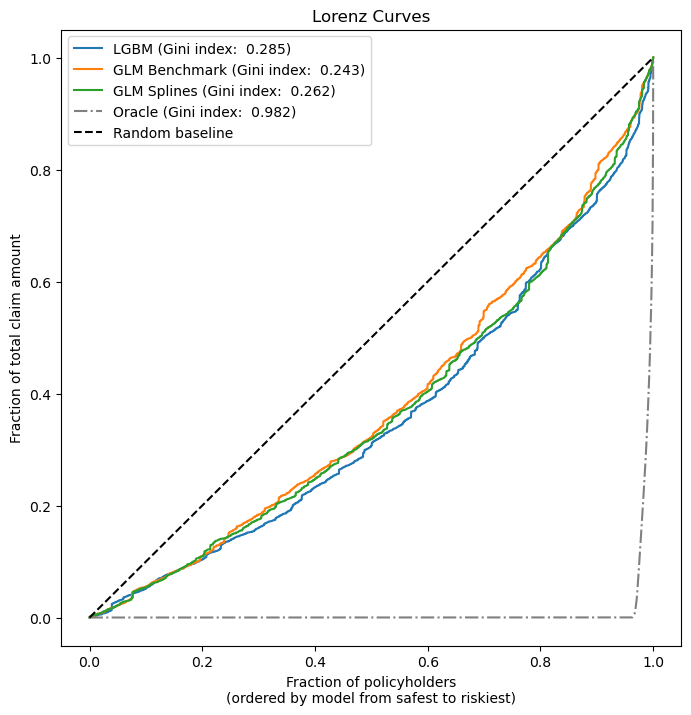

In [7]:
# Let's compare the sorting of the pure premium predictions
# Source: https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html
def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


fig, ax = plt.subplots(figsize=(8, 8))

for label, y_pred in [
    ("LGBM", df_test["pp_t_lgbm"]),
    ("GLM Benchmark", df_test["pp_t_glm1"]),
    ("GLM Splines", df_test["pp_t_glm2"]),
]:
    ordered_samples, cum_claims = lorenz_curve(
        df_test["PurePremium"], y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += f" (Gini index: {gini: .3f})"
    ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
    df_test["PurePremium"], df_test["PurePremium"], df_test["Exposure"]
)
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = f"Oracle (Gini index: {gini: .3f})"
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray", label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel="Fraction of policyholders\n(ordered by model from safest to riskiest)",
    ylabel="Fraction of total claim amount",
)
ax.legend(loc="upper left")
plt.plot()
